In [2]:
import numpy as np
import pennylane as qml

# set the random seed
np.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    #rotate around the X,Y,Z
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)
    
    #broadcast a CNOT across all wires
    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    
    #rotate around the X,Y,Z again
    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)
    
    #broadcast a CNOT across all wires
    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [3]:
# initial parameters
params = np.random.random([6])

print("Parameters:", params)
print("Expectation value:", circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871565


In [4]:
print(circuit.draw())

 0: ──RX(0.375)──╭C─────────────────╭X──RX(0.599)──╭C──────╭X──╭┤ ⟨Y ⊗ Z⟩ 
 1: ──RY(0.951)──╰X──╭C──RY(0.156)──│──────────────╰X──╭C──│───│┤         
 2: ──RZ(0.732)──────╰X─────────────╰C──RZ(0.156)──────╰X──╰C──╰┤ ⟨Y ⊗ Z⟩ 



In [5]:
def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))

-0.06518877224958126


In [6]:
def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients

print(parameter_shift(circuit, params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  2.77555756e-17]


In [7]:
grad_function = qml.grad(circuit)
print(grad_function(params)[0])

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  2.77555756e-17]


In [8]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", mutable=False)
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [9]:
# initialize circuit parameters
params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=15)
print(params.size)
print(circuit(params))

180
0.8947771876917632


In [10]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.005108700000000255 sec per loop


In [11]:
# create the gradient function
grad_fn = qml.grad(circuit)
circuit.qtape = None

times = timeit.repeat("grad_fn(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 2.1509327899999997 sec per loop


In [12]:
print(2 * forward_time * params.size)

1.8391320000000917


In [13]:
import tensorflow as tf

dev = qml.device("default.qubit", wires=4)

In [14]:
@qml.qnode(dev, diff_method="backprop", interface="tf")
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=15)
params = tf.Variable(params)
print(circuit(params))

tf.Tensor(0.9358535378025423, shape=(), dtype=float64)


In [15]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num
print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.11173407999999938 sec per loop


In [16]:
with tf.GradientTape(persistent=True) as tape:
    res = circuit(params)

times = timeit.repeat("tape.gradient(res, params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num
print(f"Backward pass (best of {reps}): {backward_time} sec per loop")

Backward pass (best of 3): 0.17856046999999933 sec per loop


In [17]:
dev = qml.device("default.qubit", wires=4)

def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [18]:
reps = 2
num = 3

forward_shift = []
gradient_shift = []
forward_backprop = []
gradient_backprop = []

for depth in range(0, 21):
    params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=depth)
    num_params = params.size
    params = tf.Variable(params)

    # forward pass timing
    # ===================

    qnode_shift = qml.QNode(circuit, dev, interface="tf", diff_method="parameter-shift", mutable=False)
    qnode_backprop = qml.QNode(circuit, dev, interface="tf", diff_method="backprop", mutable=False)

    # parameter-shift
    t = timeit.repeat("qnode_shift(params)", globals=globals(), number=num, repeat=reps)
    forward_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qnode_backprop(params)", globals=globals(), number=num, repeat=reps)
    forward_backprop.append([num_params, min(t) / num])

    if num_params == 0:
        continue

    # Gradient timing
    # ===============

    qnode_shift = qml.QNode(circuit, dev, interface="tf", diff_method="parameter-shift", mutable=False)
    qnode_backprop = qml.QNode(circuit, dev, interface="tf", diff_method="backprop", mutable=False)

    # parameter-shift
    with tf.GradientTape(persistent=True) as tape:
        res = qnode_shift(params)

    t = timeit.repeat("tape.gradient(res, params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])

    # backprop
    with tf.GradientTape(persistent=True) as tape:
        res = qnode_backprop(params)

    t = timeit.repeat("tape.gradient(res, params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])

gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

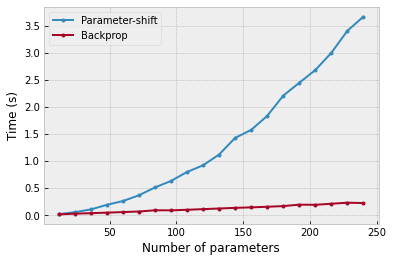

In [19]:
from matplotlib import pyplot as plt
plt.style.use("bmh")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of parameters")
ax.legend()

plt.show()

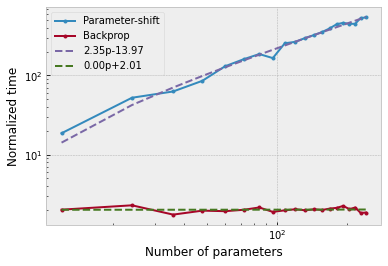

In [20]:
gradient_shift[1] /= forward_shift[1, 1:]
gradient_backprop[1] /= forward_backprop[1, 1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")

# perform a least squares regression to determine the linear best fit/gradient
# for the normalized time vs. number of parameters
x = gradient_shift[0]
m_shift, c_shift = np.polyfit(*gradient_shift, deg=1)
m_back, c_back = np.polyfit(*gradient_backprop, deg=1)

ax.plot(x, m_shift * x + c_shift, '--', label=f"{m_shift:.2f}p{c_shift:+.2f}")
ax.plot(x, m_back * x + c_back, '--', label=f"{m_back:.2f}p{c_back:+.2f}")

ax.set_ylabel("Normalized time")
ax.set_xlabel("Number of parameters")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.show()